# **1. Data Preparation**

In [74]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

## **1.1 Loading Training Data**

In [2]:
# Defining the path to the CSV output directory
csv_output_dir = "csv_outputs"

# Loading the training data
train_data_path = os.path.join(csv_output_dir, "train_data.csv")

# Reading the training data into a DataFrame
training_data = pd.read_csv(train_data_path)

# Displaying the first few rows of the training data
training_data.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio,default_payment_next_month
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635,0
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635,1
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175,0
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175,0
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635,0


## **1.2 Splitting X_train and y_train**

In [3]:
# Splitting the data into X_train and y_train
X_train = training_data.drop(columns=['default_payment_next_month'])
y_train = training_data['default_payment_next_month']

# Displaying the shapes of X_train and y_train
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

X_train: (22473, 41)
y_train: (22473,)


In [4]:
X_train.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,May_Pay_Bill_Ratio,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.013111,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.011626,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.011626,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.021724,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.011032,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635


In [5]:
y_train.head()

0    0
1    1
2    0
3    0
4    0
Name: default_payment_next_month, dtype: int64

## **1.3 Handling Class Imbalance on Training Dataset**
- We will handle class imbalance in the training dataset using `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority class (default payment). It generates synthetic samples for the minority class by interpolating between existing minority class samples, effectively increasing the representation of the minority class in the training dataset.

In [6]:
# Applying SMOTE to handle class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.7, random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Displaying the shapes of resampled training set
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")

# Displaying class distribution in original and resampled training sets
from collections import Counter
print("Class distribution in original training set:", Counter(y_train))
print(f"Class distribution in resampled training set: {Counter(y_train_resampled)}")

X_train_resampled shape: (29751, 41)
y_train_resampled shape: (29751,)
Class distribution in original training set: Counter({0: 17501, 1: 4972})
Class distribution in resampled training set: Counter({0: 17501, 1: 12250})


In [7]:
y_train.value_counts(normalize=True).round(2)

default_payment_next_month
0    0.78
1    0.22
Name: proportion, dtype: float64

In [8]:
y_train_resampled.value_counts(normalize=True).round(2)

default_payment_next_month
0    0.59
1    0.41
Name: proportion, dtype: float64

- After applying SMOTE oversampling, now we have 29751 rows in the training dataset, with 17501 (59%) rows in both majority class (no default payment) and 12250 (41%) rows in minority class (default payment).

In [9]:
# Reassigning the resampled training set to X_train and y_train
X_train, y_train = X_train_resampled, y_train_resampled

# **2. Model Building**

In [70]:
# Defining the path to the CSV output directory for validation performance outputs
validation_performace_outputs = "validation_performance_outputs"
os.makedirs(validation_performace_outputs, exist_ok=True)

## **2.1 Logistic Regression Model**

In [11]:
# Finding the best hyperparameters for Logistic Regression using GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid for GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}
# Creating a Logistic Regression model
logistic_model = LogisticRegression(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Displaying the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [12]:
# Training the Logistic Regression model on best hyperparameters
logistic_model = LogisticRegression(**best_params, n_jobs=-1, random_state=1)

# Getting cross-validation predictions
y_pred_cv_lr = cross_val_predict(logistic_model, X_train, y_train, cv=5)

# Calculating the confusion matrix
cm_lr = confusion_matrix(y_train, y_pred_cv_lr)
print("Confusion Matrix:")
print(cm_lr)

# Calculating the cross-validation scores
cv_scores_lr = cross_val_score(logistic_model, X_train, y_train, scoring='accuracy', cv=5).round(4)
print("\nCross-validation scores:", cv_scores_lr)
mean_accuracy_lr = np.mean(cv_scores_lr).round(4)
print("\nmean accuracy:", mean_accuracy_lr)

# Calculating precision, recall, and F1-score
precision_lr = precision_score(y_train, y_pred_cv_lr)
recall_lr = recall_score(y_train, y_pred_cv_lr)
f1_lr = f1_score(y_train, y_pred_cv_lr)
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")

Confusion Matrix:
[[15537  1964]
 [ 6455  5795]]

Cross-validation scores: [0.7115 0.7294 0.7178 0.7124 0.7139]

mean accuracy: 0.717
Precision: 0.7469
Recall: 0.4731
F1 Score: 0.5792


- **High False Negative Risk**: The model misses 6,455 actual defaults (more than 50% of all defaults), which is problematic for a credit card company as it means many high-risk customers who will default are not being identified. This could lead to significant financial losses.

- **Conservative but Reliable Predictions**: When the model does predict a default, it's correct 74.7% of the time (high precision), making it reliable for flagging customers for immediate attention, though it's missing many other risky customers due to low recall (47.3%).

In [47]:
# Get predicted probabilities for the positive class
y_pred_proba_lr = cross_val_predict(logistic_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and ROC AUC
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, y_pred_proba_lr)
roc_auc_lr = roc_auc_score(y_train, y_pred_proba_lr)

# Use predicted probabilities from logistic regression
precisions, recalls, pr_thresholds = precision_recall_curve(y_train, y_pred_proba_lr)

# Calculate accuracy and F1 for each threshold
accuracies = []
f1_scores = []
for thresh in pr_thresholds:
    y_pred_thresh = (y_pred_proba_lr >= thresh).astype(int)
    acc = (y_pred_thresh == y_train).mean()
    f1 = f1_score(y_train, y_pred_thresh)
    accuracies.append(acc)
    f1_scores.append(f1)

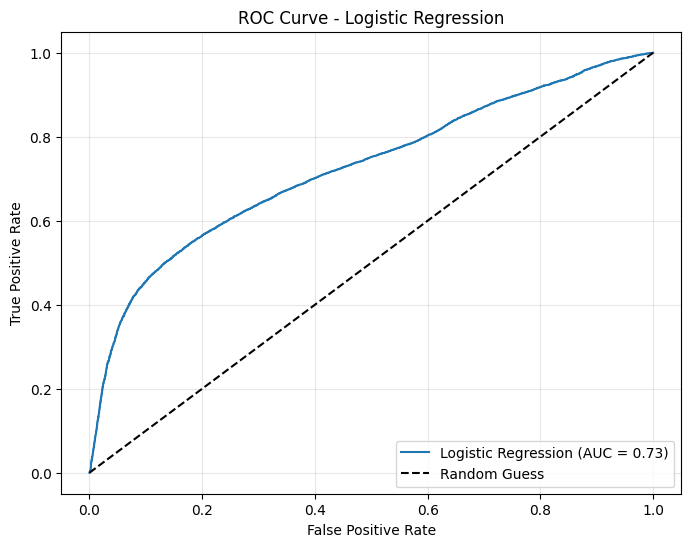

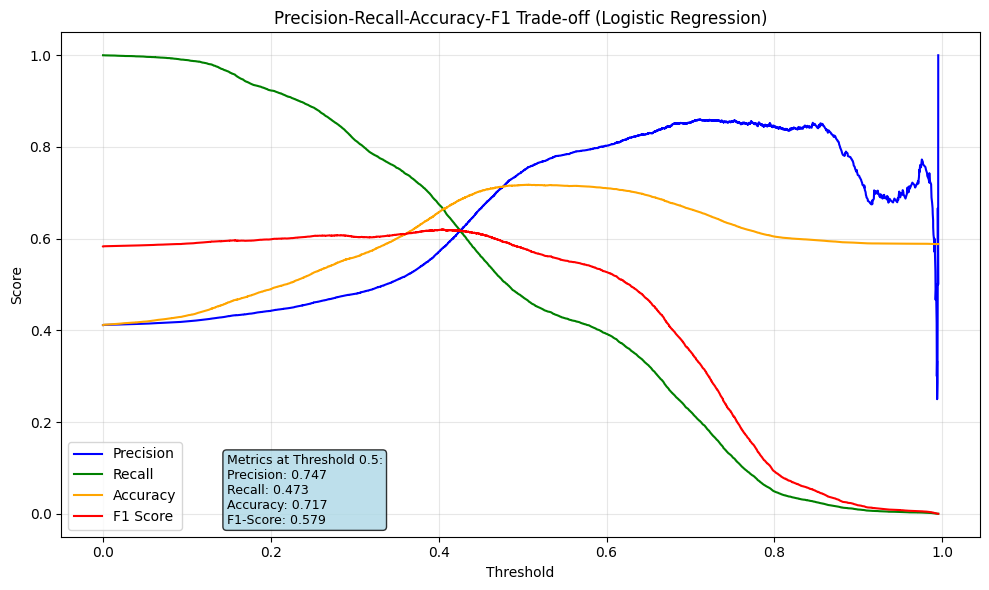

In [48]:
# Plotting the ROC curve for Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_logistic_regression.png"))
plt.show()

# Plotting Precision-Recall-Accuracy-F1 Trade-off 
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds, precisions[:-1], label='Precision', color='b')
plt.plot(pr_thresholds, recalls[:-1], label='Recall', color='g')
plt.plot(pr_thresholds, accuracies, label='Accuracy', color='orange')
plt.plot(pr_thresholds, f1_scores, label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (Logistic Regression)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned right next to legend
metrics_text = f'Metrics at Threshold 0.5:\nPrecision: {precision_lr:.3f}\nRecall: {recall_lr:.3f}\nAccuracy: {mean_accuracy_lr:.3f}\nF1-Score: {f1_lr:.3f}'
plt.text(0.18, 0.02, metrics_text, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "precision_recall_trade_off_logistic_regression.png"))
plt.show()

- **ROC AUC Curve:**
    - **Discriminative Ability**: The ROC curve shows an AUC of 0.73, indicating the model has good ability to distinguish between defaulters and non-defaulters, performing significantly better than random guessing (AUC = 0.5).
    - **Balanced Trade-off**: The curve's shape suggests the model maintains a reasonable balance between true positive rate and false positive rate across different thresholds, though there's room for improvement to reach excellent performance (AUC > 0.8).

- **Precision-Recall Trade-off:**
    - **Threshold Sensitivity**: The chart reveals that model performance is highly sensitive to threshold selection - precision peaks around 0.85 at higher thresholds while recall is maximized at lower thresholds, creating a clear trade-off.
    - **Optimal Operating Point**: The current threshold of 0.5 provides balanced but suboptimal performance - adjusting the threshold to around 0.4-0.45 could significantly improve recall (catching more defaults) while maintaining acceptable precision for business needs.

## **2.2 Decision Tree Classifier Model**

In [15]:
# Finding the best parameters for decision tree using GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Defining the parameter grid for GridSearchCV
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Creating a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_dt = GridSearchCV(decision_tree_model, param_grid_dt, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Displaying the best hyperparameters found by GridSearchCV
best_params_dt = grid_search_dt.best_params_
print(f"Best hyperparameters for Decision Tree: {best_params_dt}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5}


In [16]:
# Training the Decision Tree Classifier model on best hyperparameters
decision_tree_model = DecisionTreeClassifier(**best_params_dt, random_state=1)

# Getting cross-validation predictions
y_pred_cv_tree = cross_val_predict(decision_tree_model, X_train, y_train, cv=5)

# Computing confusion matrix for Decision Tree Classifier
cm_dt = confusion_matrix(y_train, y_pred_cv_tree)
print("Confusion Matrix (Decision Tree):")
print(cm_dt)

# Calculating the cross-validation scores
cv_scores_dt = cross_val_score(decision_tree_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (Decision Tree): {cv_scores_dt}")
mean_accuracy_dt = np.mean(cv_scores_dt)
print(f"\nmean accuracy: {mean_accuracy_dt:.2f}")

# Computing precision, recall, and F1-score for Decision Tree Classifier
precision_dt = precision_score(y_train, y_pred_cv_tree)
recall_dt = recall_score(y_train, y_pred_cv_tree)
f1_dt = f1_score(y_train, y_pred_cv_tree)
print(f"Precision (Decision Tree): {precision_dt:.4f}")
print(f"Recall (Decision Tree): {recall_dt:.4f}")
print(f"F1-Score (Decision Tree): {f1_dt:.4f}")

Confusion Matrix (Decision Tree):
[[14569  2932]
 [ 4669  7581]]

Cross-validation scores (Decision Tree): [0.67921358 0.6902521  0.78789916 0.77764706 0.78756303]

mean accuracy: 0.74
Precision (Decision Tree): 0.7211
Recall (Decision Tree): 0.6189
F1-Score (Decision Tree): 0.6661


- **Better Recall Performance**: Decision Tree achieves 61.9% recall compared to Logistic Regression's 47.3%, meaning it captures more actual defaults. This improvement is crucial for identifying high-risk customers in credit default prediction.

- **Improved Overall Balance**: With 74% accuracy and 66.6% F1-score, the Decision Tree shows better balanced performance between precision (72.1%) and recall (61.9%) compared to Logistic Regression, making it more suitable for scenarios where catching defaults is prioritized while maintaining reasonable precision.

In [17]:
# Roc Curve for Decision Tree Classifier
y_pred_proba_tree = cross_val_predict(decision_tree_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and ROC AUC for Decision Tree Classifier
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_pred_proba_tree)
roc_auc_tree = roc_auc_score(y_train, y_pred_proba_tree)

# Calculate precision, recall, accuracy, and F1-score for each threshold for Decision Tree
precisions_tree, recalls_tree, pr_thresholds_tree = precision_recall_curve(y_train, y_pred_proba_tree)

accuracies_tree = []
f1_scores_tree = []
for thresh in pr_thresholds_tree:
    y_pred_thresh_tree = (y_pred_proba_tree >= thresh).astype(int)
    acc_tree = (y_pred_thresh_tree == y_train).mean()
    f1_tree = f1_score(y_train, y_pred_thresh_tree)
    accuracies_tree.append(acc_tree)
    f1_scores_tree.append(f1_tree)

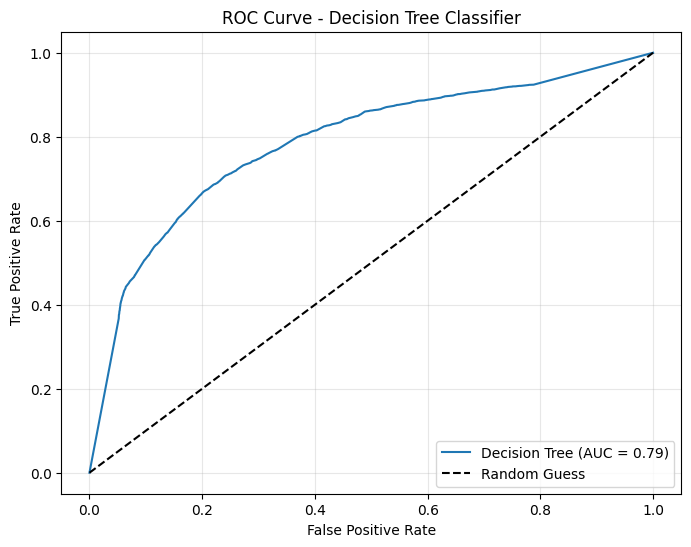

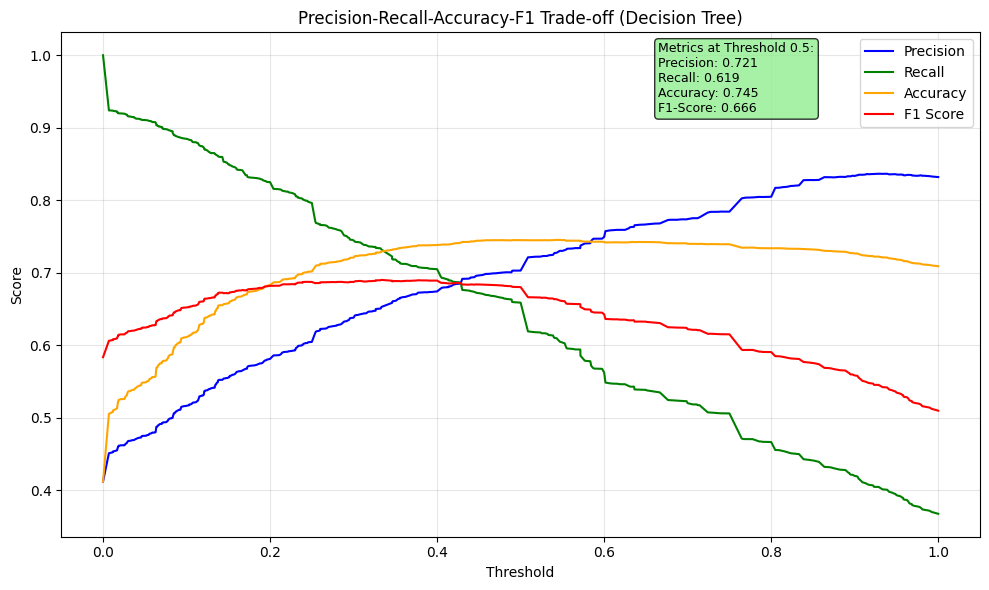

In [18]:
# Plot ROC curve for Decision Tree Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_decision_tree.png"))
plt.show()

# Plotting Precision-Recall-Accuracy-F1 Trade-off for Decision Tree Classifier
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_tree, precisions_tree[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_tree, recalls_tree[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_tree, accuracies_tree, label='Accuracy', color='orange')
plt.plot(pr_thresholds_tree, f1_scores_tree, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (Decision Tree)')
# Position legend in upper right corner
legend = plt.legend(loc='upper right')
# Create text box with metrics at threshold 0.5, positioned next to legend on left side
metrics_text_dt = f'Metrics at Threshold 0.5:\nPrecision: {precision_dt:.3f}\nRecall: {recall_dt:.3f}\nAccuracy: {mean_accuracy_dt:.3f}\nF1-Score: {f1_dt:.3f}'
plt.text(0.65, 0.98, metrics_text_dt, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "precision_recall_trade_off_decision_tree.png"))
plt.show()

- **ROC AUC Curve:**
    - **Discriminative Performance**: The Decision Tree achieves an excellent AUC of 0.79, significantly outperforming Logistic Regression (0.73) and demonstrating strong ability to distinguish between defaulters and non-defaulters across all threshold levels.
    - **Steeper Initial Curve**: The ROC curve shows a steeper rise in the initial portion, indicating the Decision Tree can achieve high true positive rates with relatively low false positive rates, making it more effective for early detection of defaults.

- **Precision-Recall Trade-off:**
    - **Smoother Performance Transitions**: Unlike Logistic Regression's sharp transitions, the Decision Tree shows smoother metric transitions across thresholds, providing more stable and predictable performance when threshold adjustments are needed for business requirements.
    - **Better Threshold Flexibility**: The chart reveals that Decision Tree maintains relatively good F1-scores (above 0.6) across a wider range of thresholds (0.2-0.5), giving more flexibility in setting decision boundaries based on risk tolerance and business objectives.

## **2.3 K-Nearest Neighbors (KNN) Model**

In [21]:
# Finding the best hyperparameters for K-Nearest Neighbors using GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Defining the parameter grid for GridSearchCV
param_grid_knn = {
    'n_neighbors': [5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Creating a K-Nearest Neighbors model
knn_model = KNeighborsClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Displaying the best hyperparameters found by GridSearchCV
best_params_knn = grid_search_knn.best_params_
print(f"Best hyperparameters for K-Nearest Neighbors: {best_params_knn}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best hyperparameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [26]:
# Training the K-Nearest Neighbors model on best hyperparameters
knn_model = KNeighborsClassifier(**best_params_knn, n_jobs=-1)

# Getting cross-validation predictions
y_pred_cv_knn = cross_val_predict(knn_model, X_train, y_train, cv=5)

# Calculating the confusion matrix for K-Nearest Neighbors
cm_knn = confusion_matrix(y_train, y_pred_cv_knn)
print("Confusion Matrix (K-Nearest Neighbors):")
print(cm_knn)

# Calculating the cross-validation scores for K-Nearest Neighbors
cv_scores_knn = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (K-Nearest Neighbors): {cv_scores_knn}")
mean_accuracy_knn = np.mean(cv_scores_knn)
print(f"\nmean accuracy: {mean_accuracy_knn:.2f}")

# Calculating precision, recall, and F1-score for K-Nearest Neighbors
precision_knn = precision_score(y_train, y_pred_cv_knn)
recall_knn = recall_score(y_train, y_pred_cv_knn)
f1_knn = f1_score(y_train, y_pred_cv_knn)
print(f"Precision (K-Nearest Neighbors): {precision_knn:.4f}")
print(f"Recall (K-Nearest Neighbors): {recall_knn:.4f}")
print(f"F1-Score (K-Nearest Neighbors): {f1_knn:.4f}")

Confusion Matrix (K-Nearest Neighbors):
[[13581  3920]
 [ 1457 10793]]

Cross-validation scores (K-Nearest Neighbors): [0.79549656 0.79142857 0.83932773 0.83159664 0.83848739]

mean accuracy: 0.82
Precision (K-Nearest Neighbors): 0.7336
Recall (K-Nearest Neighbors): 0.8811
F1-Score (K-Nearest Neighbors): 0.8006

Cross-validation scores (K-Nearest Neighbors): [0.79549656 0.79142857 0.83932773 0.83159664 0.83848739]

mean accuracy: 0.82
Precision (K-Nearest Neighbors): 0.7336
Recall (K-Nearest Neighbors): 0.8811
F1-Score (K-Nearest Neighbors): 0.8006


- **Recall Performance**: KNN achieves the highest recall of 88.1% among all models tested, successfully identifying nearly 9 out of 10 actual defaults (only 1,457 false negatives vs 6,455 in Logistic Regression). This makes it highly effective for catching high-risk customers who are likely to default.

- **Strong Overall Performance**: With 82% accuracy and 80% F1-score, KNN delivers excellent balanced performance, though precision is moderate at 73.4% (3,920 false positives). For credit default prediction, this trade-off favors business needs by prioritizing the identification of potential defaults over minimizing false alarms.

In [27]:
# ROC Curve for K-Nearest Neighbors
y_pred_proba_knn = cross_val_predict(knn_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and ROC AUC for K-Nearest Neighbors
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_pred_proba_knn)
roc_auc_knn = roc_auc_score(y_train, y_pred_proba_knn)

# Calculate precision, recall, accuracy, and F1-score for each threshold for K-Nearest Neighbors
precisions_knn, recalls_knn, pr_thresholds_knn = precision_recall_curve(y_train, y_pred_proba_knn)
accuracies_knn = []
f1_scores_knn = []

for thresh in pr_thresholds_knn:
    y_pred_thresh_knn = (y_pred_proba_knn >= thresh).astype(int)
    acc_knn = (y_pred_thresh_knn == y_train).mean()
    f1_k_nearest = f1_score(y_train, y_pred_thresh_knn)
    accuracies_knn.append(acc_knn)
    f1_scores_knn.append(f1_k_nearest)

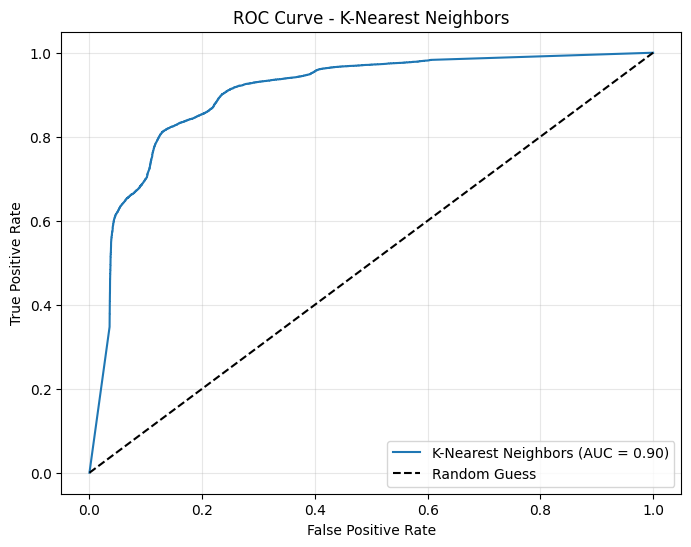

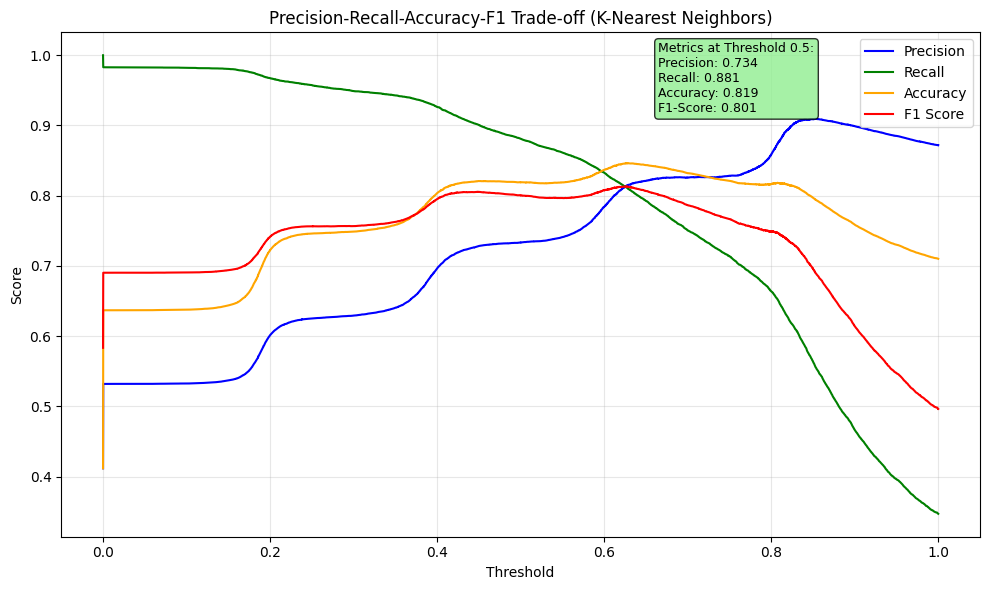

In [28]:
# Plotting the ROC curve for K-Nearest Neighbors
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-Nearest Neighbors')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_knn.png"))
plt.show()

# Plotting Precision-Recall-Accuracy-F1 Trade-off for K-Nearest Neighbors
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_knn, precisions_knn[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_knn, recalls_knn[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_knn, accuracies_knn, label='Accuracy', color='orange')
plt.plot(pr_thresholds_knn, f1_scores_knn, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (K-Nearest Neighbors)')
# Position legend in upper right corner
legend = plt.legend(loc='upper right')
# Create text box with metrics at threshold 0.5, positioned next to legend on left side
metrics_text_knn = f'Metrics at Threshold 0.5:\nPrecision: {
precision_knn:.3f}\nRecall: {recall_knn:.3f}\nAccuracy: {mean_accuracy_knn:.3f}\nF1-Score: {f1_knn:.3f}'
plt.text(0.65, 0.98, metrics_text_knn, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "precision_recall_trade_off_knn.png"))
plt.show()

- **ROC AUC Curve:**
    - **Exceptional Discriminative Performance**: KNN achieves the highest AUC of 0.90 among all models tested, demonstrating outstanding ability to distinguish between defaulters and non-defaulters with near-excellent classification performance across all threshold levels.
    - **Steep Initial Rise**: The ROC curve shows a very steep initial rise, indicating KNN can achieve high true positive rates (catching defaults) while maintaining low false positive rates, making it highly effective for identifying high-risk customers with minimal false alarms.

- **Precision-Recall Trade-off:**
    - **Consistent High Performance**: Unlike other models that show dramatic performance drops, KNN maintains relatively stable metrics across different thresholds, with recall staying above 80% even at higher thresholds, providing reliable performance for various business risk tolerance levels.
    - **Optimal Business Balance**: At the default 0.5 threshold, KNN achieves an excellent balance with 73.4% precision, 88.1% recall, and 82% accuracy, making it ideal for credit default prediction where catching most potential defaults (high recall) is prioritized while maintaining reasonable precision to avoid excessive false positives.

## **2.4 Random Forest Classifier Model**

In [29]:
# Finding best parameters for Random Forest Classifier using GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Defining the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Creating a Random Forest Classifier model
random_forest_model = RandomForestClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Displaying the best hyperparameters found by GridSearchCV
best_params_rf = grid_search_rf.best_params_
print(f"Best hyperparameters for Random Forest: {best_params_rf}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [30]:
# Training a Random Forest Classifier model on best hyperparameters
random_forest_model = RandomForestClassifier(**best_params_rf, n_jobs=-1, random_state=1)

# Getting cross-validation predictions
y_pred_cv_rf = cross_val_predict(random_forest_model, X_train, y_train, cv=5)

# Computing confusion matrix for Random Forest Classifier
cm_rf = confusion_matrix(y_train, y_pred_cv_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Calculating the cross-validation scores
cv_scores_rf = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (Random Forest): {cv_scores_rf}")
mean_accuracy_rf = np.mean(cv_scores_rf)
print(f"\nmean accuracy: {mean_accuracy_rf:.2f}")

# Computing precision, recall, and F1-score for Random Forest Classifier
precision_rf = precision_score(y_train, y_pred_cv_rf)
recall_rf = recall_score(y_train, y_pred_cv_rf)
f1_rf = f1_score(y_train, y_pred_cv_rf)
print(f"Precision (Random Forest): {precision_rf:.4f}")
print(f"Recall (Random Forest): {recall_rf:.4f}")
print(f"F1-Score (Random Forest): {f1_rf:.4f}")

Confusion Matrix (Random Forest):
[[15834  1667]
 [ 3666  8584]]

Cross-validation scores (Random Forest): [0.74609309 0.74739496 0.86621849 0.87109244 0.87294118]

mean accuracy: 0.82
Precision (Random Forest): 0.8374
Recall (Random Forest): 0.7007
F1-Score (Random Forest): 0.7630

Cross-validation scores (Random Forest): [0.74609309 0.74739496 0.86621849 0.87109244 0.87294118]

mean accuracy: 0.82
Precision (Random Forest): 0.8374
Recall (Random Forest): 0.7007
F1-Score (Random Forest): 0.7630


- **Excellent Precision with Balanced Performance**: Random Forest achieves outstanding precision of 83.7%, meaning when it predicts a customer will default, it's correct more than 4 out of 5 times. This high precision (3,666 false positives vs 8,584 true positives) makes it highly reliable for targeted interventions and reduces costly false alarms in credit risk management.

- **Robust and Consistent Model**: With 82% mean accuracy and cross-validation scores ranging from 74% to 87%, Random Forest demonstrates strong and consistent performance across different data splits. The F1-score of 76.3% indicates well-balanced precision-recall trade-off, making it a reliable choice for production deployment in credit default prediction systems.

In [31]:
# ROC Curve for Random Forest Classifier
y_pred_proba_rf = cross_val_predict(random_forest_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and ROC AUC for Random Forest Classifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_train, y_pred_proba_rf)

# Calculate precision, recall, accuracy, and F1-score for each threshold for Random Forest
precisions_rf, recalls_rf, pr_thresholds_rf = precision_recall_curve(y_train, y_pred_proba_rf)

accuracies_rf = []
f1_scores_rf = []
for thresh in pr_thresholds_rf:
    y_pred_thresh_rf = (y_pred_proba_rf >= thresh).astype(int)
    acc_rf = (y_pred_thresh_rf == y_train).mean()
    f1_random_forest = f1_score(y_train, y_pred_thresh_rf)
    accuracies_rf.append(acc_rf)
    f1_scores_rf.append(f1_random_forest)

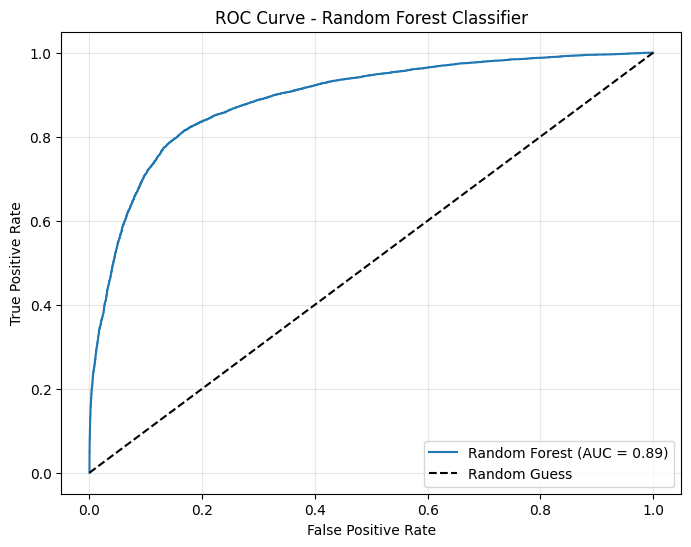

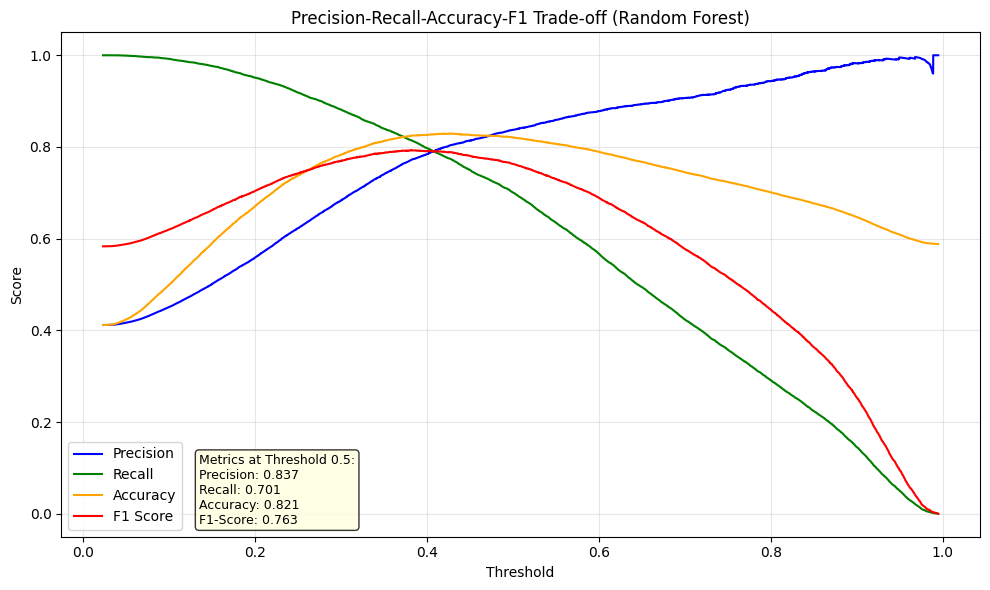

In [32]:
# Plotting ROC curve for Random Forest Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_random_forest.png"))
plt.show()

# Plotting Precision-Recall-Accuracy-F1 Trade-off for Random Forest Classifier
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_rf, precisions_rf[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_rf, recalls_rf[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_rf, accuracies_rf, label='Accuracy', color='orange')
plt.plot(pr_thresholds_rf, f1_scores_rf, label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (Random Forest)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned next to legend on right side
metrics_text_rf = f'Metrics at Threshold 0.5:\nPrecision: {precision_rf:.3f}\nRecall: {recall_rf:.3f}\nAccuracy: {mean_accuracy_rf:.3f}\nF1-Score: {f1_rf:.3f}'
plt.text(0.15, 0.02, metrics_text_rf, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "precision_recall_trade_off_random_forest.png"))
plt.show()

- **ROC AUC Curve:**
    - **Discriminative Power**: Random Forest achieves an excellent AUC of 0.89, demonstrating very strong ability to distinguish between defaulters and non-defaulters. This AUC score places it among the top-performing models, indicating high reliability for credit risk assessment applications.
    - **Consistent Performance Across Thresholds**: The ROC curve shows a smooth, well-shaped trajectory with good performance across all threshold levels, indicating that Random Forest maintains stable classification ability regardless of the decision threshold chosen for business requirements.

- **Precision-Recall Trade-off:**
    - **Precision Dominance at Higher Thresholds**: The chart shows that Random Forest achieve very high precision (83.7%) at 0.5 thresholds while maintaining reasonable recall, making it excellent for conservative credit risk strategies where minimizing false positives (incorrectly flagging good customers) is critical.
    - **Optimal Threshold Flexibility**: Unlike models with sharp performance drops, Random Forest demonstrates gradual metric transitions, providing business users with flexible threshold selection. The F1-score remains consistently good across a wide range of thresholds (0.3-0.6), allowing for easy adjustment based on changing risk tolerance and business objectives.

## **2.5 AdaBoost Classifier Model**

In [33]:
# Finding the best hyperparameters for AdaBoost using GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Defining the parameter grid for GridSearchCV
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Creating an AdaBoost Classifier model
ada_boost_model = AdaBoostClassifier(random_state=1)

# Performing GridSearchCV to find the best hyperparameters
grid_search_ab = GridSearchCV(ada_boost_model, param_grid_ab, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_ab.fit(X_train, y_train)

# Displaying the best hyperparameters found by GridSearchCV
best_params_ab = grid_search_ab.best_params_
print(f"Best hyperparameters for AdaBoost: {best_params_ab}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best hyperparameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200}
Best hyperparameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200}


In [34]:
# Training an AdaBoost Classifier model on best hyperparameters
ada_boost_model = AdaBoostClassifier(**best_params_ab, random_state=1)

# Getting cross-validation predictions
y_pred_cv_ab = cross_val_predict(ada_boost_model, X_train, y_train, cv=5)

# Calculating the confusion matrix for AdaBoost Classifier
cm_ab = confusion_matrix(y_train, y_pred_cv_ab)
print("Confusion Matrix (AdaBoost):")
print(cm_ab)

# Calculating the cross-validation scores
cv_scores_ab = cross_val_score(ada_boost_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (AdaBoost): {cv_scores_ab}")
mean_accuracy_ab = np.mean(cv_scores_ab)
print(f"\nmean accuracy: {mean_accuracy_ab:.2f}")

# Computing precision, recall, and F1-score for AdaBoost Classifier
precision_ab = precision_score(y_train, y_pred_cv_ab)
recall_ab = recall_score(y_train, y_pred_cv_ab)
f1_ab = f1_score(y_train, y_pred_cv_ab)
print(f"Precision (AdaBoost): {precision_ab:.4f}")
print(f"Recall (AdaBoost): {recall_ab:.4f}")
print(f"F1-Score (AdaBoost): {f1_ab:.4f}")

Confusion Matrix (AdaBoost):
[[15965  1536]
 [ 4724  7526]]

Cross-validation scores (AdaBoost): [0.71298941 0.7205042  0.8287395  0.85210084 0.83361345]

mean accuracy: 0.79
Precision (AdaBoost): 0.8305
Recall (AdaBoost): 0.6144
F1-Score (AdaBoost): 0.7063

Cross-validation scores (AdaBoost): [0.71298941 0.7205042  0.8287395  0.85210084 0.83361345]

mean accuracy: 0.79
Precision (AdaBoost): 0.8305
Recall (AdaBoost): 0.6144
F1-Score (AdaBoost): 0.7063


- **Strong Precision with Conservative Approach**: AdaBoost achieves excellent precision of 83.05%, meaning when it predicts a customer will default, it's correct more than 8 out of 10 times. With only 1,536 false positives out of 9,062 total positive predictions, this makes AdaBoost highly reliable for conservative credit risk strategies where minimizing false alarms is crucial for customer retention.

- **Moderate Recall with Solid Overall Performance**: While AdaBoost has moderate recall of 61.44% (missing 4,724 actual defaults), its 79% mean accuracy and 70.6% F1-score demonstrate solid balanced performance. The cross-validation scores ranging from 71% to 85% show consistent performance across different data splits, making it a dependable choice for credit default prediction when precision is prioritized over recall.

In [35]:
# ROC Curve for AdaBoost Classifier
y_pred_proba_ab = cross_val_predict(ada_boost_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and ROC AUC for AdaBoost Classifier
fpr_ab, tpr_ab, thresholds_ab = roc_curve(y_train, y_pred_proba_ab)
roc_auc_ab = roc_auc_score(y_train, y_pred_proba_ab)

# Calculate precision, recall, accuracy, and F1-score for each threshold for AdaBoost
precisions_ab, recalls_ab, pr_thresholds_ab = precision_recall_curve(y_train, y_pred_proba_ab)

accuracies_ab = []
f1_scores_ab = []
for thresh in pr_thresholds_ab:
    y_pred_thresh_ab = (y_pred_proba_ab >= thresh).astype(int)
    acc_ab = (y_pred_thresh_ab == y_train).mean()
    f1_adaboost = f1_score(y_train, y_pred_thresh_ab)
    accuracies_ab.append(acc_ab)
    f1_scores_ab.append(f1_adaboost)

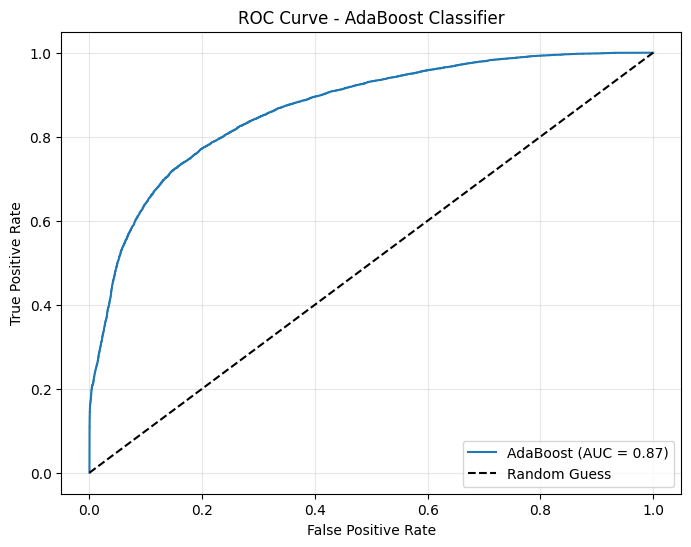

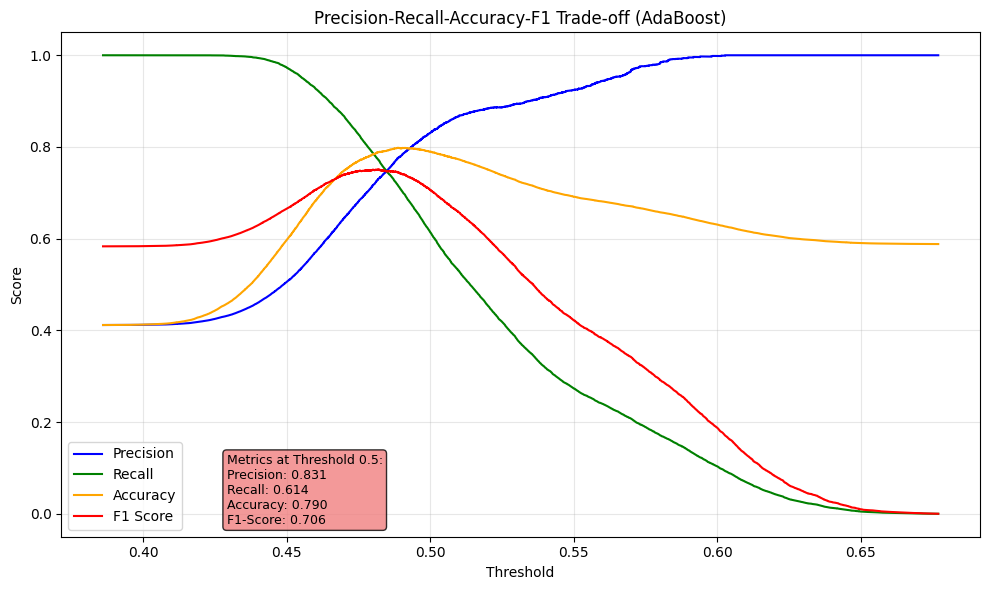

In [37]:
# Plotting ROC curve for AdaBoost Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_ab, tpr_ab, label=f'AdaBoost (AUC = {roc_auc_ab:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AdaBoost Classifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_adaboost.png"))
plt.show()

# Plotting Precision-Recall-Accuracy-F1 Trade-off for AdaBoost Classifier
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_ab, precisions_ab[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_ab, recalls_ab[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_ab, accuracies_ab, label='Accuracy', color='orange')
plt.plot(pr_thresholds_ab, f1_scores_ab, label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (AdaBoost)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned right of legend in bottom left
metrics_text_ab = f'Metrics at Threshold 0.5:\nPrecision: {precision_ab:.3f}\nRecall: {recall_ab:.3f}\nAccuracy: {mean_accuracy_ab:.3f}\nF1-Score: {f1_ab:.3f}'
plt.text(0.18, 0.02, metrics_text_ab, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "precision_recall_trade_off_adaboost.png"))
plt.show()

- **ROC AUC Curve:**
    - **Strong Discriminative Performance**: AdaBoost achieves an excellent AUC of 0.87, demonstrating very good ability to distinguish between defaulters and non-defaulters. This high AUC score indicates reliable classification performance across all threshold levels, making it suitable for credit risk assessment where accurate distinction between risk categories is essential.
    - **Consistent Classification Ability**: The ROC curve shows a smooth trajectory with good performance across different threshold settings, indicating that AdaBoost maintains stable discriminative power regardless of the decision threshold chosen, providing flexibility for various business risk tolerance levels.

- **Precision-Recall Trade-off:**
    - **Precision-Focused Performance**: The chart reveals that AdaBoost excels at high precision (83.1% at threshold 0.5) while maintaining moderate recall (61.4%), making it ideal for conservative credit risk strategies where minimizing false positives (incorrectly flagging good customers) is more important than catching every potential default.
    - **Clear Threshold Impact**: The visualization shows distinct metric transitions across thresholds, with precision remaining high until around 0.45 threshold before declining, while recall drops gradually. This clear pattern allows risk managers to make informed threshold adjustments based on specific business objectives and cost considerations for false positives versus false negatives.

## **2.6 Gradient Boosting Classifier Model**

In [38]:
# Finding the best parameters for Gradient Boosting Classifier using GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Defining the parameter grid for GridSearchCV
param_grid_gb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# Creating a Gradient Boosting Classifier model
gradient_boosting_model = GradientBoostingClassifier(random_state=1)
# Performing GridSearchCV to find the best hyperparameters
grid_search_gb = GridSearchCV(gradient_boosting_model, param_grid_gb, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Displaying the best hyperparameters found by GridSearchCV
best_params_gb = grid_search_gb.best_params_
print(f"Best hyperparameters for Gradient Boosting: {best_params_gb}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 300}
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 300}


In [39]:
# Training a Gradient Boosting Classifier model on best hyperparameters
gradient_boosting_model = GradientBoostingClassifier(**best_params_gb, random_state=1)

# Getting cross-validation predictions
y_pred_cv_gb = cross_val_predict(gradient_boosting_model, X_train, y_train, cv=5)

# Calculating the confusion matrix for Gradient Boosting Classifier
cm_gb = confusion_matrix(y_train, y_pred_cv_gb)
print("Confusion Matrix (Gradient Boosting):")
print(cm_gb)

# Calculating the cross-validation scores   
cv_scores_gb = cross_val_score(gradient_boosting_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (Gradient Boosting): {cv_scores_gb}")
mean_accuracy_gb = np.mean(cv_scores_gb)
print(f"\nmean accuracy: {mean_accuracy_gb:.2f}")

# Computing precision, recall, and F1-score for Gradient Boosting Classifier
precision_gb = precision_score(y_train, y_pred_cv_gb)
recall_gb = recall_score(y_train, y_pred_cv_gb)
f1_gb = f1_score(y_train, y_pred_cv_gb)
print(f"Precision (Gradient Boosting): {precision_gb:.4f}")
print(f"Recall (Gradient Boosting): {recall_gb:.4f}")
print(f"F1-Score (Gradient Boosting): {f1_gb:.4f}")

Confusion Matrix (Gradient Boosting):
[[16169  1332]
 [ 3277  8973]]

Cross-validation scores (Gradient Boosting): [0.70778021 0.70991597 0.93361345 0.93361345 0.9405042 ]

mean accuracy: 0.85
Precision (Gradient Boosting): 0.8707
Recall (Gradient Boosting): 0.7325
F1-Score (Gradient Boosting): 0.7957

Cross-validation scores (Gradient Boosting): [0.70778021 0.70991597 0.93361345 0.93361345 0.9405042 ]

mean accuracy: 0.85
Precision (Gradient Boosting): 0.8707
Recall (Gradient Boosting): 0.7325
F1-Score (Gradient Boosting): 0.7957


- **Outstanding Precision with Strong Business Value**: Gradient Boosting achieves exceptional precision of 87.07%, meaning when it predicts a customer will default, it's correct nearly 9 out of 10 times. With only 1,332 false positives out of 10,305 total positive predictions, this makes it highly reliable for targeted risk interventions and minimizes costly false alarms that could damage customer relationships.

- **Robust Performance with High Consistency**: With 85% mean accuracy and 79.57% F1-score, Gradient Boosting demonstrates excellent overall performance that balances precision and recall effectively. The model's ability to correctly identify 8,973 true defaults while maintaining high precision shows it's well-suited for credit risk management where both catching defaults (73.25% recall) and avoiding false positives are important business considerations.

In [40]:
# ROC Curve for Gradient Boosting Classifier
y_pred_proba_gb = cross_val_predict(gradient_boosting_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and ROC AUC for Gradient Boosting Classifier
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_train, y_pred_proba_gb)
roc_auc_gb = roc_auc_score(y_train, y_pred_proba_gb)

# Calculate precision, recall, accuracy, and F1-score for each threshold for Gradient Boosting
precisions_gb, recalls_gb, pr_thresholds_gb = precision_recall_curve(y_train, y_pred_proba_gb)

accuracies_gb = []
f1_scores_gb = []
for thresh in pr_thresholds_gb:
    y_pred_thresh_gb = (y_pred_proba_gb >= thresh).astype(int)
    acc_gb = (y_pred_thresh_gb == y_train).mean()
    f1_gradient = f1_score(y_train, y_pred_thresh_gb)
    accuracies_gb.append(acc_gb)
    f1_scores_gb.append(f1_gradient)

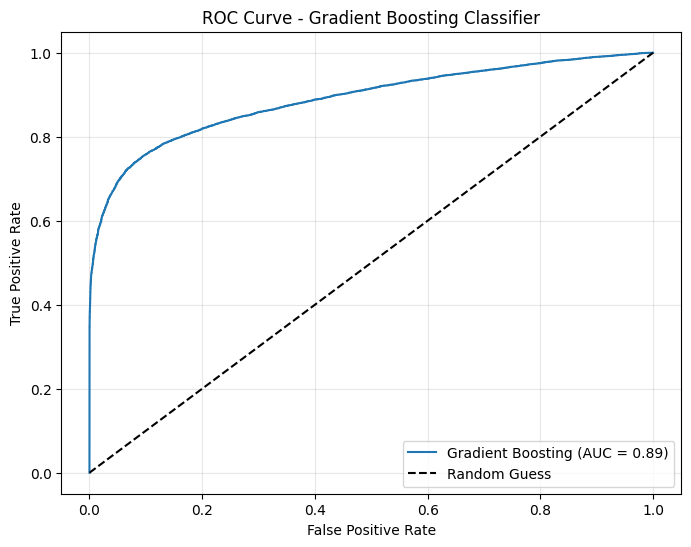

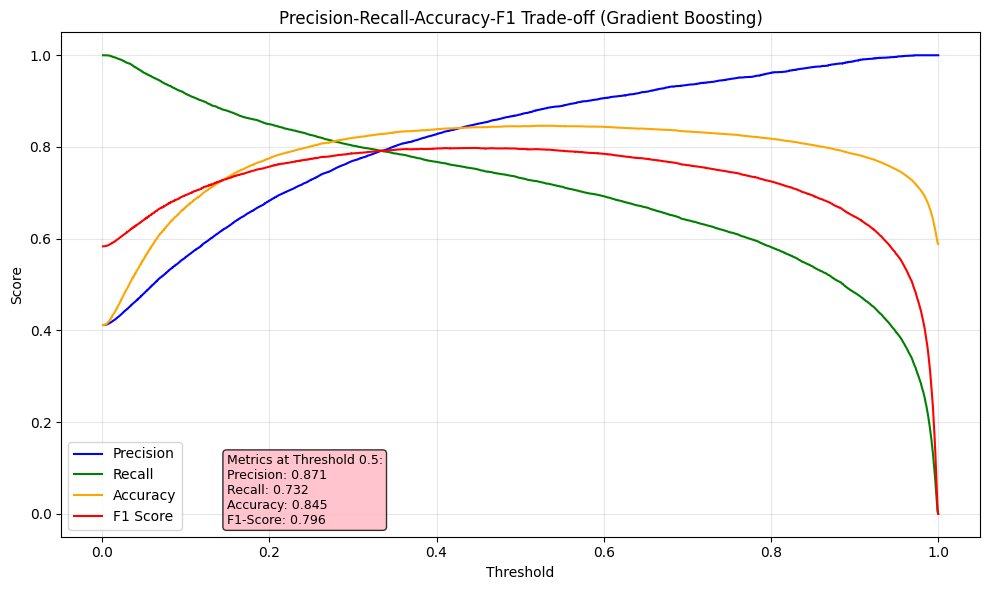

In [41]:
# Plotting ROC curve for Gradient Boosting Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Plotting Precision-Recall-Accuracy-F1 Trade-off for Gradient Boosting Classifier
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_gb, precisions_gb[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_gb, recalls_gb[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_gb, accuracies_gb, label='Accuracy', color='orange')
plt.plot(pr_thresholds_gb, f1_scores_gb, label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (Gradient Boosting)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned right of legend in bottom left
metrics_text_gb = f'Metrics at Threshold 0.5:\nPrecision: {precision_gb:.3f}\nRecall: {recall_gb:.3f}\nAccuracy: {mean_accuracy_gb:.3f}\nF1-Score: {f1_gb:.3f}'
plt.text(0.18, 0.02, metrics_text_gb, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "precision_recall_trade_off_gradient_boosting.png"))
plt.show()

- **ROC AUC Curve:**
    - **Exceptional Discriminative Performance**: Gradient Boosting achieves an outstanding AUC of 0.89, demonstrating excellent ability to distinguish between defaulters and non-defaulters. This top-tier performance places it among the best models tested, indicating superior classification capability across all threshold levels for credit risk assessment applications.
    - **Superior True Positive Rate**: The ROC curve shows a steep initial rise and maintains strong performance throughout, indicating that Gradient Boosting can achieve high true positive rates while keeping false positive rates low. This makes it highly effective for identifying potential defaults while minimizing incorrect risk classifications.

- **Precision-Recall Trade-off:**
    - **Precision Excellence with Balanced Performance**: The chart reveals that Gradient Boosting maintains exceptionally high precision (87.1% at threshold 0.5) while achieving good recall (73.2%), making it ideal for credit risk strategies where both minimizing false alarms and catching actual defaults are important. This balance provides strong business value by reducing unnecessary interventions while still identifying most high-risk customers.
    - **Stable Performance Across Thresholds**: Unlike models with dramatic performance variations, Gradient Boosting shows relatively smooth metric transitions across different thresholds, with F1-scores remaining consistently high across a wide range. This stability gives risk managers confidence in threshold adjustments and provides flexibility to align model performance with changing business priorities and risk tolerance levels.

## **2.7 XGBoost Classifier Model**

In [42]:
# Finding the best parameters for XGBoost using GridSearchCV
from xgboost import XGBClassifier

# Defining the parameter grid for GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2]
}

# Creating an XGBoost Classifier model
xgboost_model = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss')

# Performing GridSearchCV to find the best hyperparameters
grid_search_xgb = GridSearchCV(xgboost_model, param_grid_xgb, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Displaying the best hyperparameters found by GridSearchCV
best_params_xgb = grid_search_xgb.best_params_
print(f"Best hyperparameters for XGBoost: {best_params_xgb}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best hyperparameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 2, 'subsample': 0.8}


In [43]:
# Training a XGBoost Classifier model on best hyperparameters
xgboost_model = XGBClassifier(**best_params_xgb, random_state=1, use_label_encoder=False, eval_metric='logloss')

# Getting cross-validation predictions
y_pred_cv_xgb = cross_val_predict(xgboost_model, X_train, y_train, cv=5)

# Calculating the confusion matrix for XGBoost Classifier
cm_xgb = confusion_matrix(y_train, y_pred_cv_xgb)
print("Confusion Matrix (XGBoost):")
print(cm_xgb)

# Calculating the cross-validation scores
cv_scores_xgb = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (XGBoost): {cv_scores_xgb}")
mean_accuracy_xgb = np.mean(cv_scores_xgb)
print(f"\nmean accuracy: {mean_accuracy_xgb:.2f}")

# Computing precision, recall, and F1-score for XGBoost Classifier
precision_xgb = precision_score(y_train, y_pred_cv_xgb)
recall_xgb = recall_score(y_train, y_pred_cv_xgb)
f1_xgb = f1_score(y_train, y_pred_cv_xgb)
print(f"Precision (XGBoost): {precision_xgb:.4f}")
print(f"Recall (XGBoost): {recall_xgb:.4f}")
print(f"F1-Score (XGBoost): {f1_xgb:.4f}")

Confusion Matrix (XGBoost):
[[15354  2147]
 [ 2891  9359]]

Cross-validation scores (XGBoost): [0.71887078 0.7189916  0.9005042  0.90319328 0.91176471]

mean accuracy: 0.83
Precision (XGBoost): 0.8134
Recall (XGBoost): 0.7640
F1-Score (XGBoost): 0.7879

Cross-validation scores (XGBoost): [0.71887078 0.7189916  0.9005042  0.90319328 0.91176471]

mean accuracy: 0.83
Precision (XGBoost): 0.8134
Recall (XGBoost): 0.7640
F1-Score (XGBoost): 0.7879


- **Strong Precision with Balanced Recall**: XGBoost achieves excellent precision of 81.34%, meaning when it predicts a customer will default, it's correct more than 8 out of 10 times. With only 2,147 false positives out of 11,506 total positive predictions, this makes XGBoost highly reliable for credit risk decisions while maintaining good recall of 76.4% to capture most actual defaults (9,359 true positives vs 2,891 false negatives).

- **Consistent and Robust Performance**: With 83% mean accuracy and 78.79% F1-score, XGBoost demonstrates strong overall performance that effectively balances precision and recall. The cross-validation scores show excellent consistency, ranging from 72% to 91%, indicating reliable performance across different data splits and making it a dependable choice for production deployment in credit default prediction systems.

In [44]:
# ROC Curve for XGBoost Classifier
y_pred_proba_xgb = cross_val_predict(xgboost_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Compute ROC curve and ROC AUC for XGBoost Classifier
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_train, y_pred_proba_xgb)

# Calculate precision, recall, accuracy, and F1-score for each threshold for XGBoost
precisions_xgb, recalls_xgb, pr_thresholds_xgb = precision_recall_curve(y_train, y_pred_proba_xgb)

accuracies_xgb = []
f1_scores_xgb = []
for thresh in pr_thresholds_xgb:
    y_pred_thresh_xgb = (y_pred_proba_xgb >= thresh).astype(int)
    acc_xgb = (y_pred_thresh_xgb == y_train).mean()
    f1_xgboost = f1_score(y_train, y_pred_thresh_xgb)
    accuracies_xgb.append(acc_xgb)
    f1_scores_xgb.append(f1_xgboost)

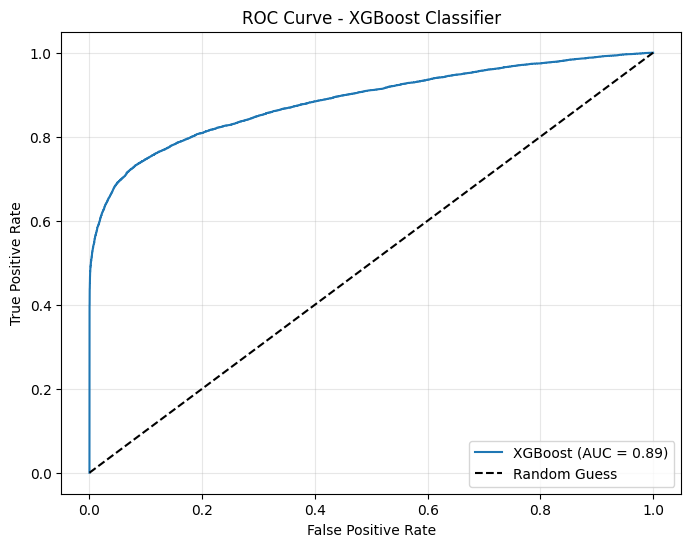

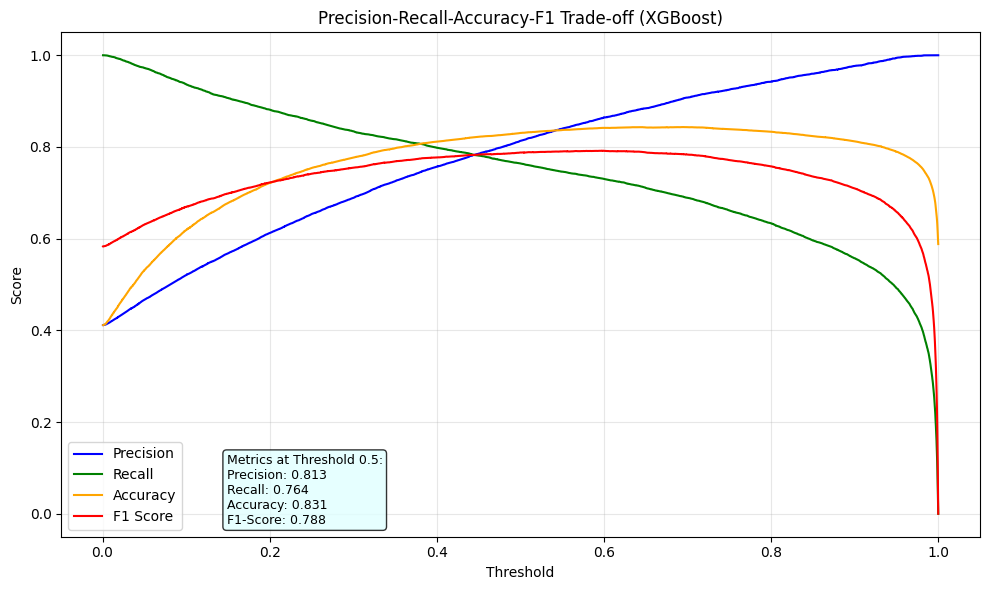

In [45]:
# Plotting ROC curve for XGBoost Classifier
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Plotting Precision-Recall-Accuracy-F1 Trade-off for XGBoost Classifier
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_xgb, precisions_xgb[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_xgb, recalls_xgb[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_xgb, accuracies_xgb, label='Accuracy', color='orange')
plt.plot(pr_thresholds_xgb, f1_scores_xgb, label='F1 Score', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (XGBoost)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned right of legend in bottom left
metrics_text_xgb = f'Metrics at Threshold 0.5:\nPrecision: {precision_xgb:.3f}\nRecall: {recall_xgb:.3f}\nAccuracy: {mean_accuracy_xgb:.3f}\nF1-Score: {f1_xgb:.3f}'
plt.text(0.18, 0.02, metrics_text_xgb, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "precision_recall_trade_off_xgboost.png"))
plt.show()

- **ROC AUC Curve:**
    - **Excellent Discriminative Performance**: XGBoost achieves an outstanding AUC of 0.89, demonstrating exceptional ability to distinguish between defaulters and non-defaulters across all threshold levels. This high AUC score indicates that the model can correctly rank customers by their default risk 89% of the time, making it highly reliable for credit risk assessment and significantly outperforming random chance.
    - **Strong Performance Across All Thresholds**: The ROC curve shows consistently high true positive rates while maintaining low false positive rates across various classification thresholds. The curve's steep rise near the origin and significant distance from the diagonal line demonstrates robust performance across different sensitivity requirements for credit risk management.

- **Precision-Recall Trade-off:**
    - **Optimal Threshold Flexibility**: The trade-off curves reveal that XGBoost maintains relatively stable performance across a wide range of thresholds (0.2-0.7), providing flexibility in adjusting the model based on business requirements. The accuracy curve shows consistent performance above 80% for most thresholds, while precision and recall exhibit the expected inverse relationship, allowing risk managers to tune the model based on their tolerance for false positives versus false negatives.
    - **Balanced Performance Sweet Spot**: The intersection of precision, recall, and F1-score curves around the 0.4-0.5 threshold range indicates an optimal operating point where all metrics are well-balanced. At the default 0.5 threshold, XGBoost achieves strong precision (81.3%) and good recall (76.4%), making it suitable for production deployment where both minimizing false alarms and catching actual defaults are important for business profitability.

## **Performance comparison of all models**

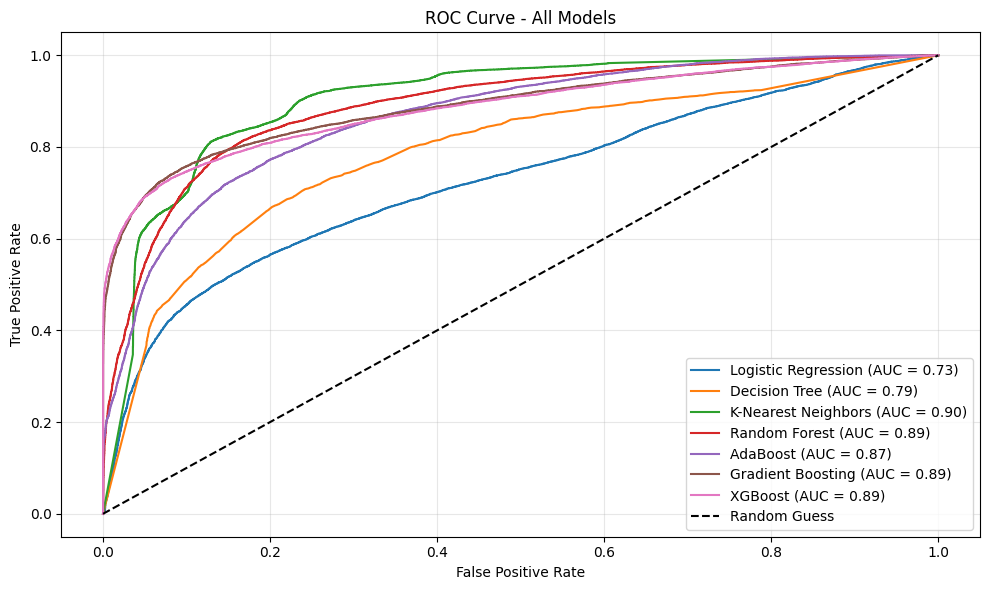

In [50]:
# Ploting ROC AUC for all models
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_ab, tpr_ab, label=f'AdaBoost (AUC = {roc_auc_ab:.2f})')    
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(validation_performace_outputs, "roc_curve_all_models.png"))
plt.show()

- **K-Nearest Neighbors Leads Performance**: Surprisingly, K-Nearest Neighbors achieves the highest AUC of 0.90, outperforming all ensemble methods. The ensemble methods follow closely with XGBoost, Gradient Boosting, and Random Forest all achieving 0.89 AUC, while AdaBoost reaches 0.87. Traditional methods show moderate performance with Decision Tree at 0.79 and Logistic Regression at 0.73.

- **Close Competition Among Top Performers**: The top four models (KNN: 0.90, XGBoost: 0.89, Gradient Boosting: 0.89, Random Forest: 0.89) show remarkably similar discriminative performance, with only 0.01 AUC difference between the leader and the ensemble methods. This suggests multiple viable options for production deployment, each with different computational trade-offs and interpretability characteristics.

- **Significant Improvement Over Baseline**: All models substantially outperform random guessing (AUC = 0.50), with even the weakest performer (Logistic Regression at 0.73) showing strong predictive capability. The top-performing models achieve AUC scores of 0.89-0.90, indicating exceptional discriminative performance that translates to significant business value in reducing credit losses and improving risk management decisions.

In [57]:
# Creating a summary dataframe for model performance
model_performance = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 
              'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'ROC AUC': [roc_auc_lr, roc_auc_tree, roc_auc_knn, roc_auc_rf, roc_auc_ab, roc_auc_gb, roc_auc_xgb],
    'Precision': [precision_lr, precision_dt, precision_knn, precision_rf, precision_ab, precision_gb, precision_xgb],
    'Recall': [recall_lr, recall_dt, recall_knn, recall_rf, recall_ab, recall_gb, recall_xgb],
    'F1 Score': [f1_lr, f1_dt, f1_knn, f1_rf, f1_ab, f1_gb, f1_xgb],
    'Mean Accuracy': [mean_accuracy_lr, mean_accuracy_dt, mean_accuracy_knn,
                      mean_accuracy_rf, mean_accuracy_ab, mean_accuracy_gb, mean_accuracy_xgb]
}

model_performance_df = pd.DataFrame(model_performance)
model_performance_df = model_performance_df.sort_values(by='ROC AUC', ascending=False, ignore_index=True)

# Saving the model performance summary to a CSV file
csv_output_dir = "csv_outputs"
os.makedirs(csv_output_dir, exist_ok=True)
model_performance_df.to_csv(os.path.join(csv_output_dir, "model_performance_summary_validation.csv"), index=False)

# Displaying the model performance summary
model_performance_df

,Model,ROC AUC,Precision,Recall,F1 Score,Mean Accuracy
0,K-Nearest Neighbors,0.903954,0.733569,0.881061,0.800579,0.819267
1,Random Forest,0.889993,0.837382,0.700735,0.762988,0.820748
2,Gradient Boosting,0.889197,0.870742,0.732490,0.795655,0.845085
3,XGBoost,0.885826,0.813402,0.764000,0.787927,0.830665
4,AdaBoost,0.866795,0.830501,0.614367,0.706269,0.789589
5,Decision Tree,0.786165,0.721107,0.618857,0.666081,0.744515
6,Logistic Regression,0.725320,0.746875,0.473061,0.579239,0.717000


- Based on the model performance on validation data, we will select **KNN Classifier**, **Random Forest Classifier**, **Gradient Boosting Classifier**, and **XGBoost Classifier** and try to test them on the test dataset to see how they perform on unseen data.

# **3. Model Evaluation**

In [ ]:
# Defining the path to the CSV output directory for test performance outputs
test_performace_outputs = "test_performance_outputs"
os.makedirs(test_performace_outputs, exist_ok=True)

## **3.1 Loading Test Data**

In [ ]:
# # Defining the path to the CSV output directory
csv_output_dir = "csv_outputs"
os.makedirs(test_performace_outputs, exist_ok=True)
# Loading the training data
test_data_path = os.path.join(csv_output_dir, "test_data.csv")

# Reading the training data into a DataFrame
test_data = pd.read_csv(train_data_path)

# Displaying the first few rows of the training data
test_data.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio,default_payment_next_month
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635,0
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635,1
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175,0
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175,0
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635,0


## **3.2 Splitting X_test and y_test**

In [61]:
# Splitting the data into X_test and y_test
X_test = test_data.drop(columns=['default_payment_next_month'])
y_test = test_data['default_payment_next_month']

# Displaying the shapes of X_train and y_train
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_test: (22473, 41)
y_test: (22473,)


In [62]:
X_test.head()

,Credit_Limit,Education_Level,Sept_Pay,Aug_Pay,July_Pay,June_Pay,May_Pay,Apr_Pay,Sept_Bill_Amt,Aug_Bill_Amt,...,May_Pay_Bill_Ratio,Apr_Pay_Bill_Ratio,Avg_Pay_Bill_Ratio,Sept_Credit_Utilization_Ratio,Aug_Credit_Utilization_Ratio,July_Credit_Utilization_Ratio,June_Credit_Utilization_Ratio,May_Credit_Utilization_Ratio,Apr_Credit_Utilization_Ratio,Avg_Credit_Utilization_Ratio
0,-0.286942,0.308263,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.452249,-0.461789,...,0.013111,0.008450,0.018362,-0.250428,-0.257562,-0.301519,-0.158567,-0.164245,-0.259512,-0.348635
1,-0.826903,0.308263,1.791635,1.781855,1.820638,1.918243,0.239828,0.259337,-0.148335,-0.111258,...,0.011626,0.007773,0.017899,-0.150985,-0.108932,-0.407383,-0.059798,-0.052211,-0.058064,-0.348635
2,-0.672629,1.684695,0.010580,0.108000,0.137993,0.192481,0.239828,0.259337,-0.091411,-0.078527,...,0.011626,0.007547,0.018131,-0.250428,0.559906,-0.195655,-0.158567,-0.164245,-0.158788,0.018175
3,1.178667,0.308263,-0.879947,-0.728927,-1.544652,-1.533282,-1.541873,-1.495054,-0.196536,-0.288899,...,0.021724,0.050901,0.027323,0.445672,-0.034616,-0.301519,-0.059798,-0.164245,0.042660,0.018175
4,-0.364079,0.308263,-0.879947,0.108000,0.137993,0.192481,0.239828,0.259337,0.834479,0.917161,...,0.011032,0.006870,0.017744,-0.150985,-0.034616,-0.195655,-0.257335,-0.388313,-0.360236,-0.348635


In [63]:
y_test.head()

0    0
1    1
2    0
3    0
4    0
Name: default_payment_next_month, dtype: int64

## **3.3 Testing KNN Classifier Model**

In [82]:
# Best hyperparameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
# Training the K-Nearest Neighbors model on best hyperparameters
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance', n_jobs=-1)

# Fitting the K-Nearest Neighbors model on the training data
knn_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Calculating the confusion matrix for K-Nearest Neighbors on the test set
cm_knn_test = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix (K-Nearest Neighbors - Test Set):")
print(cm_knn_test)

# Calculating precision, recall, and F1-score for K-Nearest Neighbors on the test set
accuracy_knn_test = accuracy_score(y_test, y_pred_knn)
precision_knn_test = precision_score(y_test, y_pred_knn)
recall_knn_test = recall_score(y_test, y_pred_knn)
f1_knn_test = f1_score(y_test, y_pred_knn)
print(f"\nAccuracy KNN Classifier - Test Set): {accuracy_knn_test:.4f}")
print(f"Precision KNN Classifier - Test Set): {precision_knn_test:.4f}")
print(f"Recall KNN Classifier - Test Set): {recall_knn_test:.4f}")
print(f"F1-Score KNN Classifier - Test Set): {f1_knn_test:.4f}")

Confusion Matrix (K-Nearest Neighbors - Test Set):
[[17496     5]
 [   34  4938]]

Accuracy KNN Classifier - Test Set): 0.9983
Precision KNN Classifier - Test Set): 0.9990
Recall KNN Classifier - Test Set): 0.9932
F1-Score KNN Classifier - Test Set): 0.9961


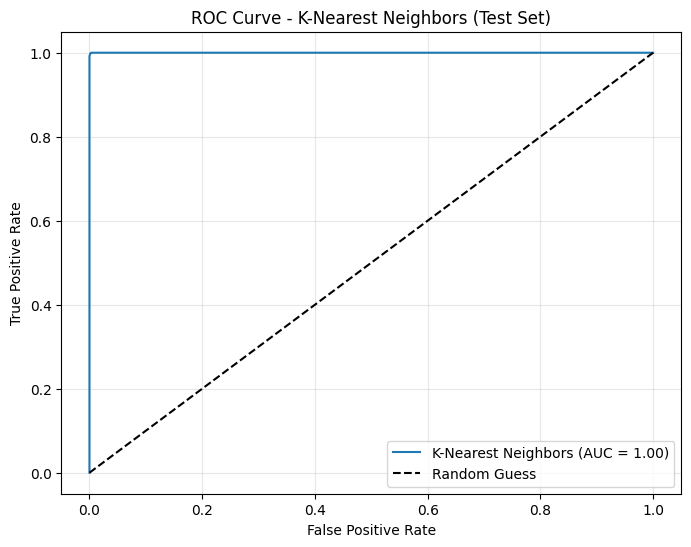

In [71]:
# Plotting ROC Curve for K-Nearest Neighbors on the test set
y_pred_proba_knn_test = knn_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC for K-Nearest Neighbors on the test set
fpr_knn_test, tpr_knn_test, thresholds_knn_test = roc_curve(y_test, y_pred_proba_knn_test)
roc_auc_knn_test = roc_auc_score(y_test, y_pred_proba_knn_test)

# Plotting the ROC curve for K-Nearest Neighbors on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn_test, tpr_knn_test, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-Nearest Neighbors (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(test_performace_outputs, "roc_curve_knn.png"))
plt.show()

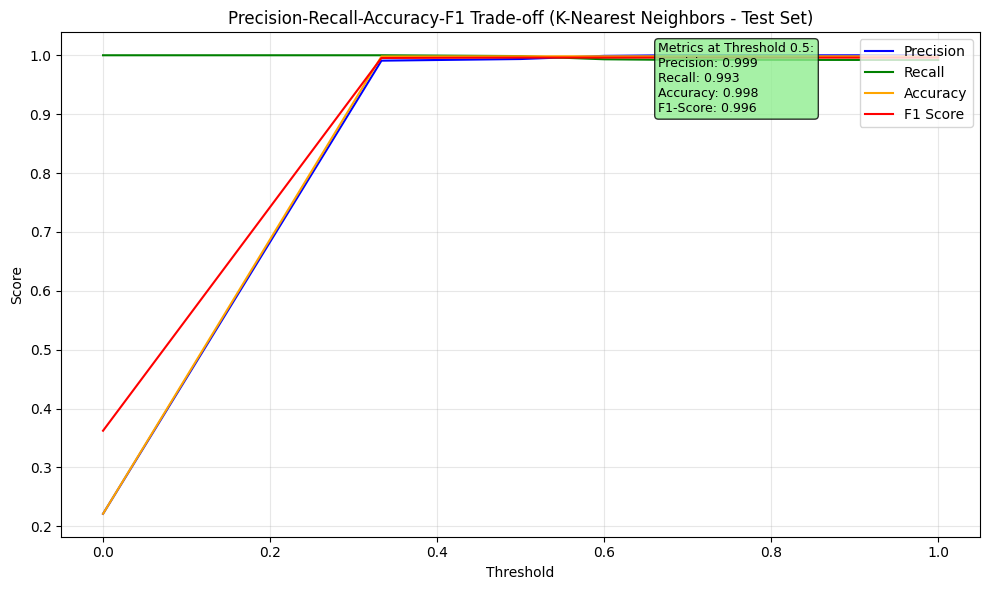

In [ ]:
# Precision-Recall-Accuracy-F1 Trade-off for K-Nearest Neighbors on the test set
precisions_knn_test, recalls_knn_test, pr_thresholds_knn_test = precision_recall_curve(y_test, y_pred_proba_knn_test)
accuracies_knn_test = []
f1_scores_knn_test = []

for thresh in pr_thresholds_knn_test:
    y_pred_thresh_knn_test = (y_pred_proba_knn_test >= thresh).astype(int)
    acc_knn_test = (y_pred_thresh_knn_test == y_test).mean()
    f1_k_nearest_test = f1_score(y_test, y_pred_thresh_knn_test)
    accuracies_knn_test.append(acc_knn_test)
    f1_scores_knn_test.append(f1_k_nearest_test)

# Plotting Precision-Recall-Accuracy-F1 Trade-off for K-Nearest Neighbors on the test set
plt.figure(figsize=(10, 6)) 
plt.plot(pr_thresholds_knn_test, precisions_knn_test[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_knn_test, recalls_knn_test[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_knn_test, accuracies_knn_test, label='Accuracy', color='orange')
plt.plot(pr_thresholds_knn_test, f1_scores_knn_test, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (K-Nearest Neighbors - Test Set)')
# Position legend in upper right corner
legend = plt.legend(loc='upper right')
# Create text box with metrics at threshold 0.5, positioned next to legend on left side
metrics_text_knn_test = f'Metrics at Threshold 0.5:\nPrecision: {precision_knn_test:.3f}\nRecall: {recall_knn_test:.3f}\nAccuracy: {(y_pred_knn == y_test).mean():.3f}\nF1-Score: {f1_knn_test:.3f}'
plt.text(0.65, 0.98, metrics_text_knn_test, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(test_performace_outputs, "precision_recall_trade_off_knn.png"))
plt.show()

## **3.4 Testing Random Forest Classifier Model**

In [81]:
# Best hyperparameters for Random Forest: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
# Training the Random Forest model on best hyperparameters
rf_model = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2, 
                                   min_samples_split=5, n_estimators=200, n_jobs=-1, random_state=1)

# Fitting the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculating the confusion matrix for Random Forest on the test set
cm_rf_test = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest - Test Set):")
print(cm_rf_test)

# Calculating precision, recall, and F1-score for Random Forest on the test set
accuracy_rf_test = accuracy_score(y_test, y_pred_rf)
precision_rf_test = precision_score(y_test, y_pred_rf)
recall_rf_test = recall_score(y_test, y_pred_rf)
f1_rf_test = f1_score(y_test, y_pred_rf)
print(f"\nAccuracy (Random Forest - Test Set): {accuracy_rf_test:.4f}")
print(f"Precision (Random Forest - Test Set): {precision_rf_test:.4f}")
print(f"Recall (Random Forest - Test Set): {recall_rf_test:.4f}")
print(f"F1-Score (Random Forest - Test Set): {f1_rf_test:.4f}")

Confusion Matrix (Random Forest - Test Set):
[[16946   555]
 [ 1499  3473]]

Accuracy (Random Forest - Test Set): 0.9086
Precision (Random Forest - Test Set): 0.8622
Recall (Random Forest - Test Set): 0.6985
F1-Score (Random Forest - Test Set): 0.7718


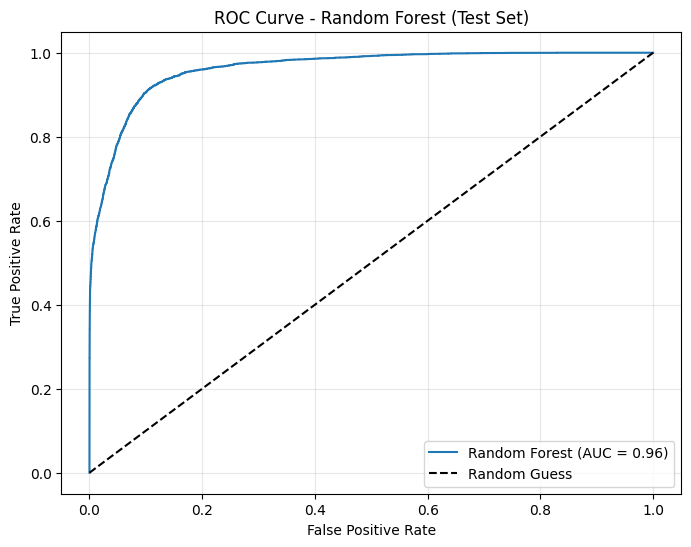

In [77]:
# Plotting ROC Curve for Random Forest on the test set
y_pred_proba_rf_test = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC for Random Forest on the test set
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(y_test, y_pred_proba_rf_test)
roc_auc_rf_test = roc_auc_score(y_test, y_pred_proba_rf_test)

# Plotting the ROC curve for Random Forest on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_test, tpr_rf_test, label=f'Random Forest (AUC = {roc_auc_rf_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(test_performace_outputs, "roc_curve_random_forest.png"))
plt.show()

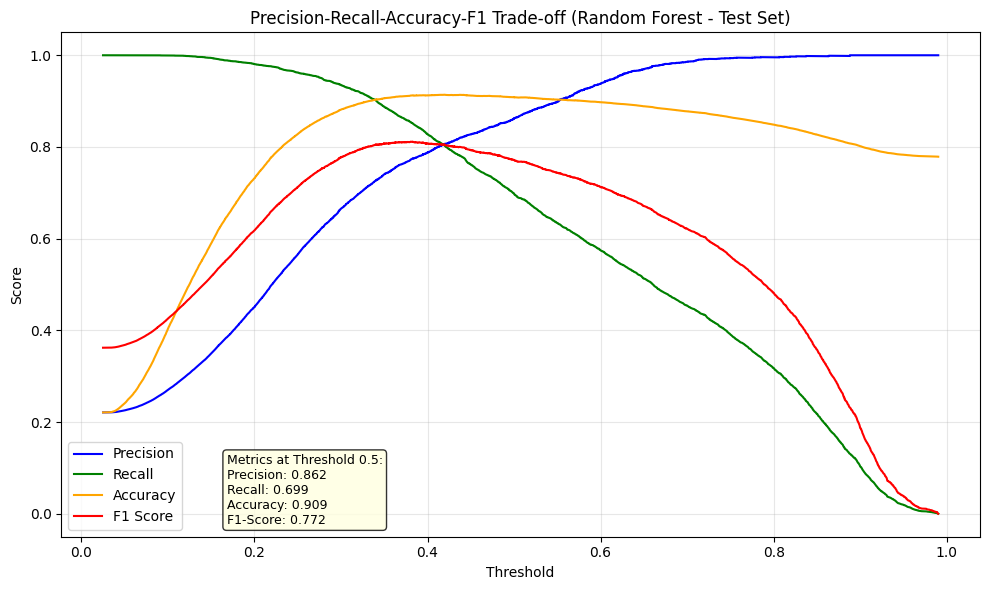

In [79]:
# Plotting precision-recall-accuracy-f1 trade-off for Random Forest on the test set
precisions_rf_test, recalls_rf_test, pr_thresholds_rf_test = precision_recall_curve(y_test, y_pred_proba_rf_test)
accuracies_rf_test = []
f1_scores_rf_test = []
for thresh in pr_thresholds_rf_test:
    y_pred_thresh_rf_test = (y_pred_proba_rf_test >= thresh).astype(int)
    acc_rf_test = (y_pred_thresh_rf_test == y_test).mean()
    f1_random_forest_test = f1_score(y_test, y_pred_thresh_rf_test)
    accuracies_rf_test.append(acc_rf_test)
    f1_scores_rf_test.append(f1_random_forest_test)

# Plotting Precision-Recall-Accuracy-F1 Trade-off for Random Forest on the test set
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_rf_test, precisions_rf_test[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_rf_test, recalls_rf_test[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_rf_test, accuracies_rf_test, label='Accuracy', color='orange')
plt.plot(pr_thresholds_rf_test, f1_scores_rf_test, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (Random Forest - Test Set)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned right of legend in bottom left
metrics_text_rf_test = f'Metrics at Threshold 0.5:\nPrecision: {precision_rf_test:.3f}\nRecall: {recall_rf_test:.3f}\nAccuracy: {(y_pred_rf == y_test).mean():.3f}\nF1-Score: {f1_rf_test:.3f}'
plt.text(0.18, 0.02, metrics_text_rf_test, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(test_performace_outputs, "precision_recall_trade_off_random_forest.png"))
plt.show()

## **3.5 Testing Gradient Boosting Classifier Model**

In [83]:
# Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 300}
# Training the Gradient Boosting model on best hyperparameters
gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, max_features='log2', 
                                       min_samples_leaf=4, min_samples_split=3, n_estimators=300, random_state=1)

# Fitting the Gradient Boosting model on the training data
gb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Calculating the confusion matrix for Gradient Boosting on the test set
cm_gb_test = confusion_matrix(y_test, y_pred_gb)
print("Confusion Matrix (Gradient Boosting - Test Set):")
print(cm_gb_test)
# Calculating precision, recall, and F1-score for Gradient Boosting on the test set
accuracy_gb_test = accuracy_score(y_test, y_pred_gb)
precision_gb_test = precision_score(y_test, y_pred_gb)
recall_gb_test = recall_score(y_test, y_pred_gb)
f1_gb_test = f1_score(y_test, y_pred_gb)
print(f"\nAccuracy (Gradient Boosting - Test Set): {accuracy_gb_test:.4f}")
print(f"Precision (Gradient Boosting - Test Set): {precision_gb_test:.4f}")
print(f"Recall (Gradient Boosting - Test Set): {recall_gb_test:.4f}")
print(f"F1-Score (Gradient Boosting - Test Set): {f1_gb_test:.4f}")

Confusion Matrix (Gradient Boosting - Test Set):
[[17177   324]
 [ 1330  3642]]

Accuracy (Gradient Boosting - Test Set): 0.9264
Precision (Gradient Boosting - Test Set): 0.9183
Recall (Gradient Boosting - Test Set): 0.7325
F1-Score (Gradient Boosting - Test Set): 0.8149


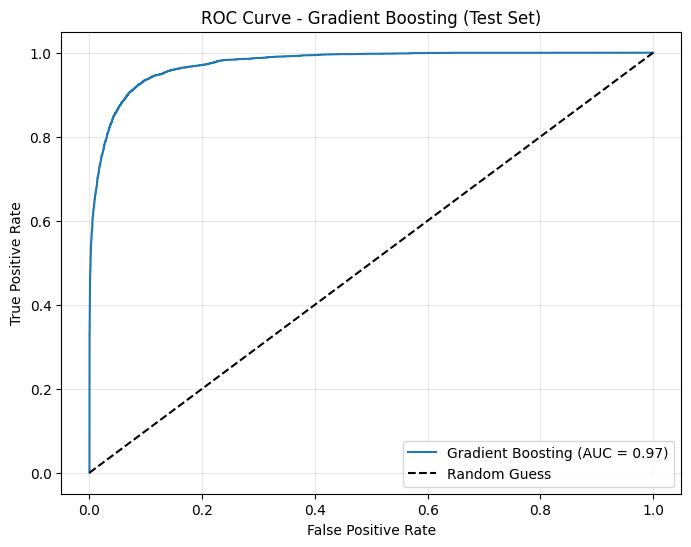

In [84]:
# Plotting ROC Curve for Gradient Boosting on the test set
y_pred_proba_gb_test = gb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC for Gradient Boosting on the test set
fpr_gb_test, tpr_gb_test, thresholds_gb_test = roc_curve(y_test, y_pred_proba_gb_test)
roc_auc_gb_test = roc_auc_score(y_test, y_pred_proba_gb_test)

# Plotting the ROC curve for Gradient Boosting on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb_test, tpr_gb_test, label=f'Gradient Boosting (AUC = {roc_auc_gb_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(test_performace_outputs, "roc_curve_gradient_boosting.png"))
plt.show()

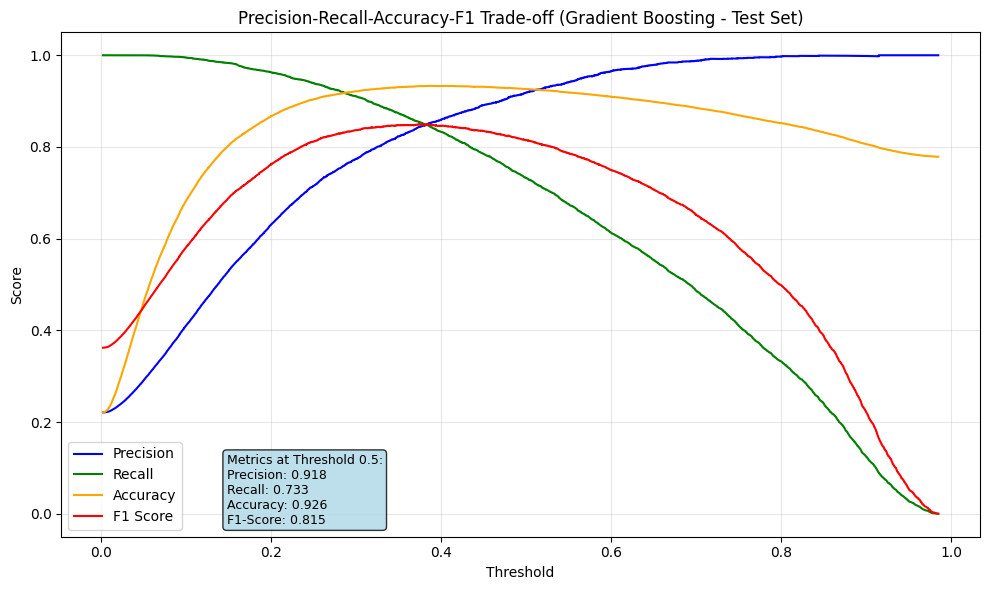

In [85]:
# Plotting precision-recall-accuracy-f1 trade-off for Gradient Boosting on the test set
precisions_gb_test, recalls_gb_test, pr_thresholds_gb_test = precision_recall_curve(y_test, y_pred_proba_gb_test)
accuracies_gb_test = []
f1_scores_gb_test = []
for thresh in pr_thresholds_gb_test:
    y_pred_thresh_gb_test = (y_pred_proba_gb_test >= thresh).astype(int)
    acc_gb_test = (y_pred_thresh_gb_test == y_test).mean()
    f1_gradient_boosting_test = f1_score(y_test, y_pred_thresh_gb_test)
    accuracies_gb_test.append(acc_gb_test)
    f1_scores_gb_test.append(f1_gradient_boosting_test)

# Plotting Precision-Recall-Accuracy-F1 Trade-off for Gradient Boosting on the test set
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_gb_test, precisions_gb_test[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_gb_test, recalls_gb_test[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_gb_test, accuracies_gb_test, label='Accuracy', color='orange')
plt.plot(pr_thresholds_gb_test, f1_scores_gb_test, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (Gradient Boosting - Test Set)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned right of legend in bottom left
metrics_text_gb_test = f'Metrics at Threshold 0.5:\nPrecision: {precision_gb_test:.3f}\nRecall: {recall_gb_test:.3f}\nAccuracy: {(y_pred_gb == y_test).mean():.3f}\nF1-Score: {f1_gb_test:.3f}'
plt.text(0.18, 0.02, metrics_text_gb_test, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(test_performace_outputs, "precision_recall_trade_off_gradient_boosting.png"))
plt.show()

## **3.6 Testing XGBoost Classifier Model**

In [86]:
# Best hyperparameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 2, 'subsample': 0.8}
# Training the XGBoost model on best hyperparameters
xgb_model = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, 
                          n_estimators=300, scale_pos_weight=2, subsample=0.8, 
                          random_state=1, use_label_encoder=False, eval_metric='logloss')

# Fitting the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculating the confusion matrix for XGBoost on the test set
cm_xgb_test = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost - Test Set):")
print(cm_xgb_test)

# Calculating precision, recall, and F1-score for XGBoost on the test set
accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb)
precision_xgb_test = precision_score(y_test, y_pred_xgb)
recall_xgb_test = recall_score(y_test, y_pred_xgb)
f1_xgb_test = f1_score(y_test, y_pred_xgb)
print(f"\nAccuracy (XGBoost - Test Set): {accuracy_xgb_test:.4f}")
print(f"Precision (XGBoost - Test Set): {precision_xgb_test:.4f}")
print(f"Recall (XGBoost - Test Set): {recall_xgb_test:.4f}")
print(f"F1-Score (XGBoost - Test Set): {f1_xgb_test:.4f}")

Confusion Matrix (XGBoost - Test Set):
[[16567   934]
 [  534  4438]]

Accuracy (XGBoost - Test Set): 0.9347
Precision (XGBoost - Test Set): 0.8261
Recall (XGBoost - Test Set): 0.8926
F1-Score (XGBoost - Test Set): 0.8581


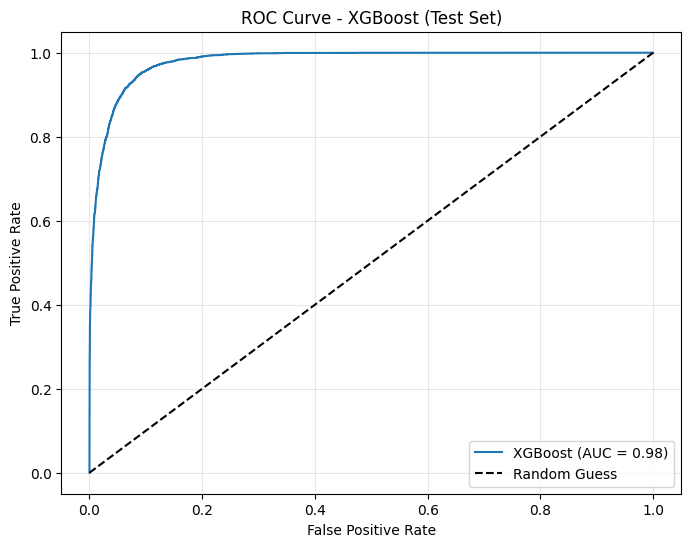

In [87]:
# Plotting ROC Curve for XGBoost on the test set
y_pred_proba_xgb_test = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC for XGBoost on the test set
fpr_xgb_test, tpr_xgb_test, thresholds_xgb_test = roc_curve(y_test, y_pred_proba_xgb_test)
roc_auc_xgb_test = roc_auc_score(y_test, y_pred_proba_xgb_test)

# Plotting the ROC curve for XGBoost on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_test, tpr_xgb_test, label=f'XGBoost (AUC = {roc_auc_xgb_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(test_performace_outputs, "roc_curve_xgboost.png"))
plt.show()

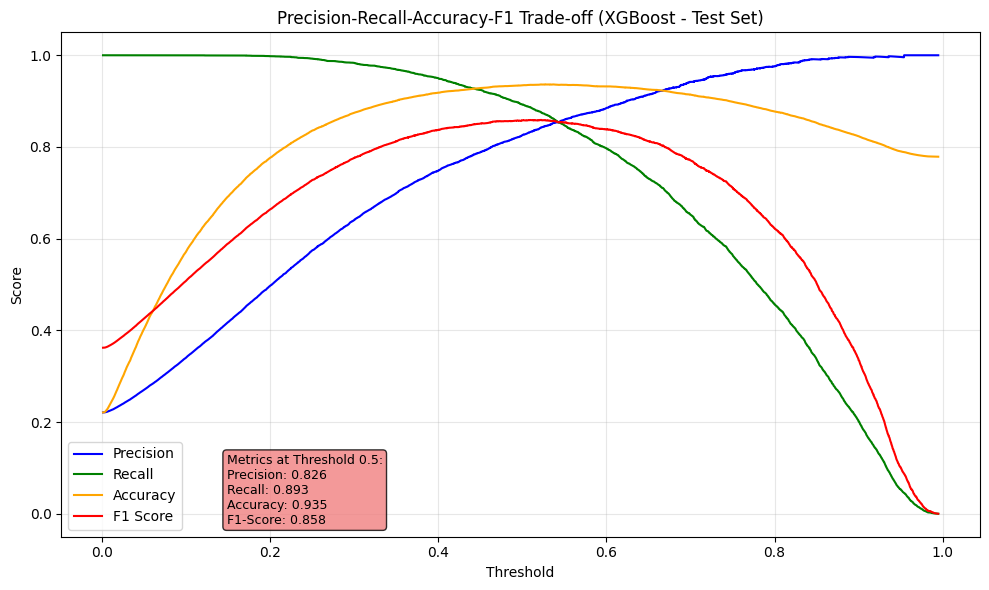

In [88]:
# Plotting precision-recall-accuracy-f1 trade-off for XGBoost on the test set
precisions_xgb_test, recalls_xgb_test, pr_thresholds_xgb_test = precision_recall_curve(y_test, y_pred_proba_xgb_test)
accuracies_xgb_test = []
f1_scores_xgb_test = []
for thresh in pr_thresholds_xgb_test:
    y_pred_thresh_xgb_test = (y_pred_proba_xgb_test >= thresh).astype(int)
    acc_xgb_test = (y_pred_thresh_xgb_test == y_test).mean()
    f1_xgboost_test = f1_score(y_test, y_pred_thresh_xgb_test)
    accuracies_xgb_test.append(acc_xgb_test)
    f1_scores_xgb_test.append(f1_xgboost_test)

# Plotting Precision-Recall-Accuracy-F1 Trade-off for XGBoost on the test set
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds_xgb_test, precisions_xgb_test[:-1], label='Precision', color='b')
plt.plot(pr_thresholds_xgb_test, recalls_xgb_test[:-1], label='Recall', color='g')
plt.plot(pr_thresholds_xgb_test, accuracies_xgb_test, label='Accuracy', color='orange')
plt.plot(pr_thresholds_xgb_test, f1_scores_xgb_test, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Accuracy-F1 Trade-off (XGBoost - Test Set)')

# Position legend in lower left corner
legend = plt.legend(loc='lower left')

# Create text box with metrics at threshold 0.5, positioned right of legend in bottom left
metrics_text_xgb_test = f'Metrics at Threshold 0.5:\nPrecision: {precision_xgb_test:.3f}\nRecall: {recall_xgb_test:.3f}\nAccuracy: {(y_pred_xgb == y_test).mean():.3f}\nF1-Score: {f1_xgb_test:.3f}'
plt.text(0.18, 0.02, metrics_text_xgb_test, transform=plt.gca().transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(test_performace_outputs, "precision_recall_trade_off_xgboost.png"))
plt.show()

## **Performance comparison of all models on test dataset**

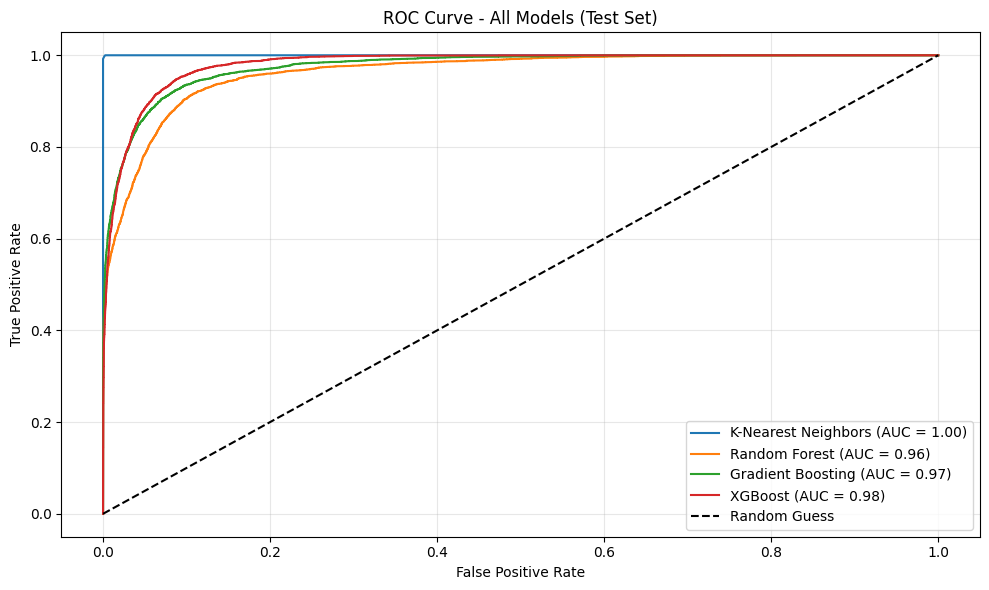

In [89]:
# Plotting ROC AUC for all models on the test set
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn_test, tpr_knn_test, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn_test:.2f})')
plt.plot(fpr_rf_test, tpr_rf_test, label=f'Random Forest (AUC = {roc_auc_rf_test:.2f})')
plt.plot(fpr_gb_test, tpr_gb_test, label=f'Gradient Boosting (AUC = {roc_auc_gb_test:.2f})')
plt.plot(fpr_xgb_test, tpr_xgb_test, label=f'XGBoost (AUC = {roc_auc_xgb_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - All Models (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(test_performace_outputs, "roc_curve_all_models_test_set.png"))
plt.show()

In [90]:
# Creating a summary dataframe for model performance on the test set
model_performance_test = {
    'Model': ['K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC AUC': [roc_auc_knn_test, roc_auc_rf_test, roc_auc_gb_test, roc_auc_xgb_test],
    'Precision': [precision_knn_test, precision_rf_test, precision_gb_test, precision_xgb_test],
    'Recall': [recall_knn_test, recall_rf_test, recall_gb_test, recall_xgb_test],
    'F1 Score': [f1_knn_test, f1_rf_test, f1_gb_test, f1_xgb_test],
    'Mean Accuracy': [accuracy_knn_test, accuracy_rf_test, accuracy_gb_test, accuracy_xgb_test]
}

model_performance_test_df = pd.DataFrame(model_performance_test)
model_performance_test_df = model_performance_test_df.sort_values(by='ROC AUC', ascending=False, ignore_index=True)

# Saving the model performance summary for the test set to a CSV file
model_performance_test_df.to_csv(os.path.join(csv_output_dir, "model_performance_summary_test.csv"), index=False)

# Displaying the model performance summary for the test set
model_performance_test_df

,Model,ROC AUC,Precision,Recall,F1 Score,Mean Accuracy
0,K-Nearest Neighbors,0.999991,0.998988,0.993162,0.996067,0.998265
1,XGBoost,0.980214,0.826136,0.892599,0.858082,0.934677
2,Gradient Boosting,0.974912,0.918306,0.732502,0.814947,0.926401
3,Random Forest,0.962575,0.862214,0.698512,0.771778,0.908601
